**Gender and Acoustic Features in Music: A Statistical Analysis**

**Objective:** This notebook investigates whether there are statistically significant differences in acoustic features between male and female artists, and whether these differences are robust to contextual factors like genre and artist identity.

**Hypotheses:**
- **H1:** There are significant differences in acoustic features between male and female artists.
- **H2:** Specific acoustic dimensions are more important for classifying artist gender.
- **H3:** The gender effect is robust to artist and genre controls.


In [1]:
pip install dash pycountry pycountry-convert scikit-learn plotly IPython jupyter-dash


Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Imports for Analysis ---
import pandas as pd
import numpy as np
import scipy.stats as stats
import re
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import fdrcorrection

# --- Global Configuration (Academic Style) ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
GENDER_PALETTE = {"Male": "#1f77b4", "Female": "#d62728"}
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- Imports for t-SNE Visualization ---
import pycountry
import pycountry_convert as pc
from sklearn.manifold import TSNE
import plotly.express as px
from IPython.display import IFrame
import dash
from dash import Dash, dcc, html, Input, Output

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Part 1: Dataset

This section provides some information about the dataset and the key features that will be analyzed.

First few rows of the relevant data:
     year gender_clean  loudness    tempo
0  2008.0         Male    -9.636  124.059
1  2004.0       Female   -11.061   80.084
2  2007.0      Unknown    -5.795   77.150
3  1982.0      Unknown    -4.264   92.897
4  1998.0      Unknown   -13.885   86.981

Summary statistics for relevant numerical columns:
              year     loudness        tempo
count  4680.000000  4680.000000  4680.000000
mean   1997.232051    -9.683453   125.163716
std      11.686691     5.135927    35.272251
min    1926.000000   -51.643000     0.000000
25%    1993.000000   -12.163000    98.698500
50%    2001.000000    -8.588500   122.226500
75%    2006.000000    -5.984500   146.572000
max    2010.000000     0.566000   258.677000


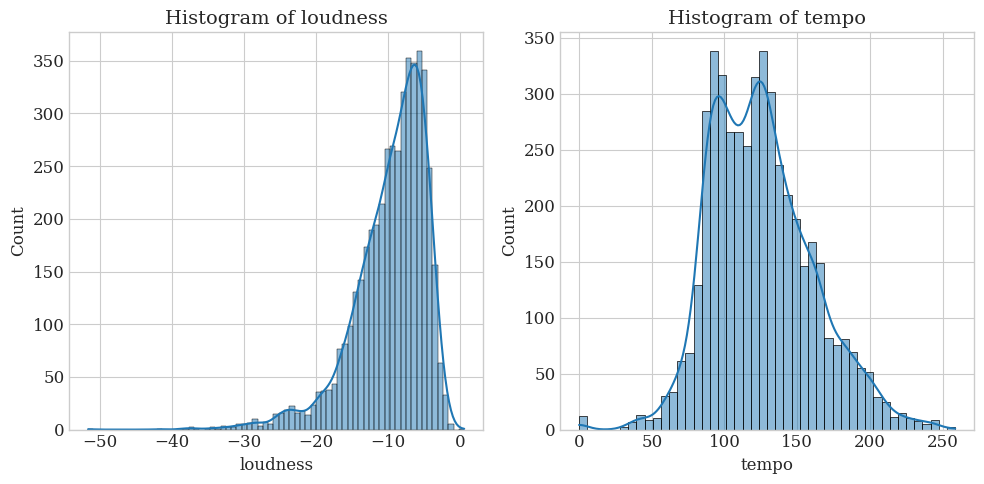

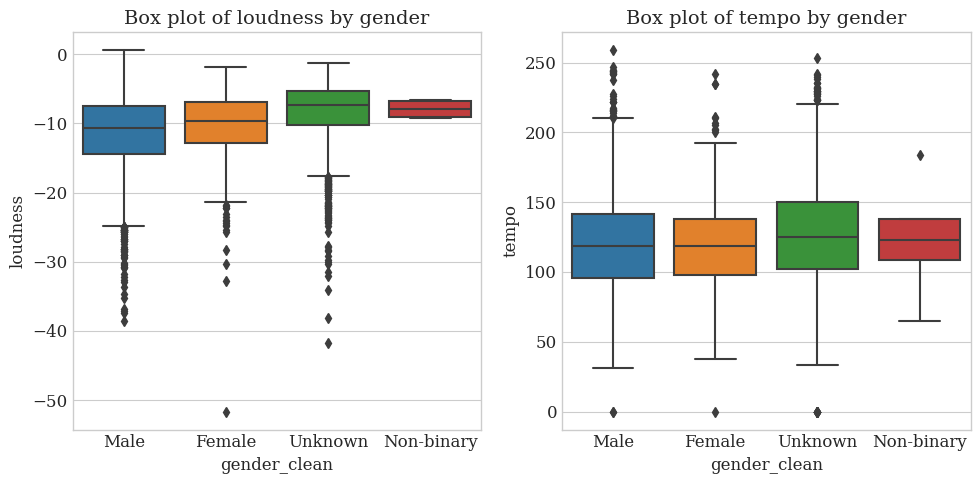

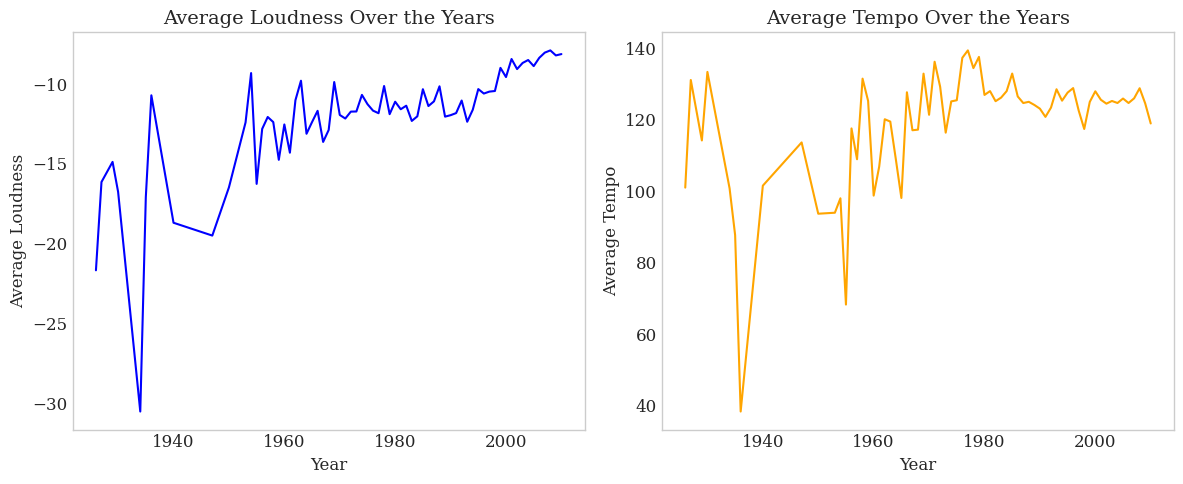

In [3]:
# Load the dataset
df = pd.read_csv('final_song_level.csv')

# Select relevant columns for analysis
relevant_columns = ['year', 'gender_clean', 'loudness', 'tempo']
df_relevant = df[relevant_columns].dropna()

# Display the first few rows of the relevant data
print("First few rows of the relevant data:")
print(df_relevant.head())

# Summary statistics for the relevant numerical columns
print("\nSummary statistics for relevant numerical columns:")
print(df_relevant.describe())

# Histograms for numerical acoustic features
acoustic_features = ['loudness', 'tempo']

plt.figure(figsize=(10, 5))
for i, feature in enumerate(acoustic_features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(df_relevant[feature], kde=True)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

# Box plots for acoustic features by gender
plt.figure(figsize=(10, 5))
for i, feature in enumerate(acoustic_features, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=df_relevant, x='gender_clean', y=feature)
    plt.title(f'Box plot of {feature} by gender')
plt.tight_layout()
plt.show()

# Separate line plots for average loudness and tempo over the years
plt.figure(figsize=(12, 5))

# Average loudness over the years
plt.subplot(1, 2, 1)
df_relevant.groupby('year')['loudness'].mean().plot(color='blue')
plt.title('Average Loudness Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Loudness')
plt.grid()

# Average tempo over the years
plt.subplot(1, 2, 2)
df_relevant.groupby('year')['tempo'].mean().plot(color='orange')
plt.title('Average Tempo Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Tempo')
plt.grid()

plt.tight_layout()
plt.show()


# Gender Analysis in Music Acoustic Data

## Research Questions

This notebook presents a comprehensive statistical analysis addressing three key research questions:

- **RQ1**: Do systematic acoustic differences exist between works associated with male and female artists?
- **RQ2**: Which acoustic dimensions contribute most strongly to any observed differences?
- **RQ3**: Do acoustic patterns vary across musical genres, suggesting genre-specific dynamics?

---

## Methodology Overview

- **Level of analysis**: Artist-level (avoiding pseudo-replication)
- **Statistical tests**: Welch's t-test with FDR correction, ANOVA with interaction, Random Forest classification
- **Effect sizes**: Cohen's d reported throughout
- **Validation**: Cross-validation, bootstrap, sensitivity analyses

---

## 1. Setup and Imports

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import re
import warnings
import os
from typing import Tuple, List, Dict, Optional

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import chi2
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Configuration

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 8),
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

GENDER_PALETTE = {"Male": "#1f77b4", "Female": "#d62728"}
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ALPHA_FDR = 0.05
MIN_TRACKS_PER_ARTIST = 1
MIN_ARTISTS_PER_GENDER = 10

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 2. Helper Functions

These functions handle data loading, cleaning, and statistical computations.

In [5]:
def classify_gender_robust(g: str) -> str:
    """Classify gender from string labels with robust pattern matching."""
    if pd.isna(g) or str(g).lower() == 'nan':
        return "Unknown"
    g = str(g).lower().strip()
    if re.search(r'\b(female|woman|femme|girl|women)\b', g):
        return "Female"
    elif re.search(r'\b(male|man|homme|boy|men)\b', g) and not re.search(r'fe(male)|wo(man|men)', g):
        return "Male"
    elif re.search(r'\b(non-binary|nonbinary|genderqueer|agender)\b', g):
        return "Non-binary"
    else:
        return "Unknown"


def compute_cohens_d(group1: np.ndarray, group2: np.ndarray) -> float:
    """Calculate Cohen's d effect size."""
    var1, var2 = group1.var(ddof=1), group2.var(ddof=1)
    pooled_std = np.sqrt((var1 + var2) / 2)
    return (group1.mean() - group2.mean()) / pooled_std if pooled_std > 1e-10 else np.nan


print("✓ Helper functions defined")

✓ Helper functions defined


## 3. Data Loading and Preparation

Load the dataset and prepare it for analysis by:
- Classifying gender labels
- Removing outliers (>5 SD)
- Filtering to binary gender categories
- Aggregating to artist level

In [6]:
def load_and_clean_data(filepath: str) -> pd.DataFrame:
    """Load data and classify gender categories."""
    try:
        df = pd.read_csv(filepath)
        df["gender_clean"] = df["gender"].apply(classify_gender_robust)
        
        print(f"✓ Data loaded: {len(df)} tracks, {df['artist_name'].nunique()} artists")
        print("\nGender distribution:")
        print(df["gender_clean"].value_counts().to_string())
        
        return df
    except FileNotFoundError:
        print(f"ERROR: '{filepath}' not found.")
        raise


# Load data
df = load_and_clean_data("final_artist_level.csv")

✓ Data loaded: 4680 tracks, 2238 artists

Gender distribution:
Unknown       2548
Male          1610
Female         518
Non-binary       4


In [7]:
def prepare_analysis_dataset(df: pd.DataFrame, acoustic_vars: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """Prepare dataset for analysis: filter, clean, aggregate to artist level."""
    df_binary = df[df["gender_clean"].isin(["Male", "Female"])].copy()
    
    required_cols = acoustic_vars + ["artist_name", "gender_clean"]
    if "genre_principal" in df.columns:
        required_cols.append("genre_principal")
    
    df_binary = df_binary.dropna(subset=required_cols)
    
    # Remove constant variables
    constant_vars = [var for var in acoustic_vars if df_binary[var].nunique() <= 1]
    if constant_vars:
        print(f"\n⚠ Constant variables removed: {constant_vars}")
        acoustic_vars = [var for var in acoustic_vars if var not in constant_vars]
    
    # Outlier detection
    print("\n[OUTLIER DETECTION]")
    n_before = len(df_binary)
    for var in acoustic_vars:
        mean, std = df_binary[var].mean(), df_binary[var].std()
        df_binary = df_binary[
            (df_binary[var] >= mean - 5*std) & 
            (df_binary[var] <= mean + 5*std)
        ]
    print(f"  Tracks removed: {n_before - len(df_binary)} ({100*(n_before-len(df_binary))/n_before:.1f}%)")
    
    # Filter artists
    artist_counts = df_binary['artist_name'].value_counts()
    valid_artists = artist_counts[artist_counts >= MIN_TRACKS_PER_ARTIST].index
    df_binary = df_binary[df_binary['artist_name'].isin(valid_artists)].copy()
    
    # Check sample sizes
    gender_counts = df_binary.groupby('gender_clean')['artist_name'].nunique()
    print(f"\n[SAMPLE SIZES]")
    for gender, count in gender_counts.items():
        print(f"  {gender}: {count} artists")
        if count < MIN_ARTISTS_PER_GENDER:
            raise ValueError(f"Insufficient artists for {gender}")
    
    # Aggregate to artist level
    agg_dict = {var: 'mean' for var in acoustic_vars}
    agg_dict['gender_clean'] = 'first'
    if 'genre_principal' in df_binary.columns:
        agg_dict['genre_principal'] = 'first'
    
    df_artist = df_binary.groupby('artist_name').agg(agg_dict).reset_index()
    
    tracks_per_artist = len(df_binary) / len(df_artist)
    print(f"\n✓ Track-level: {len(df_binary)} tracks, {len(df_artist)} artists")
    print(f"✓ Artist-level: {len(df_artist)} artists")
    print(f"✓ Average tracks/artist: {tracks_per_artist:.1f}")
    print(f"✓ Valid variables: {len(acoustic_vars)}")
    
    return df_binary, df_artist, acoustic_vars


# Define acoustic variables
ACOUSTIC_VARS = [f"timbre_{i}_mean" for i in range(12)] + \
                [f"pitch_{i}_mean" for i in range(12)] + \
                ["loudness", "tempo"]

# Prepare datasets
df_track, df_artist, acoustic_vars = prepare_analysis_dataset(df, ACOUSTIC_VARS)


⚠ Constant variables removed: ['energy', 'danceability']

[OUTLIER DETECTION]
  Tracks removed: 20 (1.2%)

[SAMPLE SIZES]
  Female: 165 artists
  Male: 583 artists

✓ Track-level: 1628 tracks, 748 artists
✓ Artist-level: 748 artists
✓ Average tracks/artist: 2.2
✓ Valid variables: 26


---

# RQ1: Univariate Analysis

## Do systematic acoustic differences exist?

**Method**: Welch's t-test (artist-level) with FDR correction for multiple testing

**Key considerations**:
- Artist-level analysis avoids pseudo-replication
- FDR correction controls Type I error rate across 26 tests
- Cohen's d quantifies practical significance

In [8]:
def univariate_analysis(df_artist: pd.DataFrame, acoustic_vars: List[str]) -> pd.DataFrame:
    """Perform univariate analysis with Welch's t-test and FDR correction."""
    print("\n" + "="*70)
    print("RQ1: UNIVARIATE ANALYSIS (Artist-Level)")
    print("="*70)
    print(f"\n[METHOD]: Welch's t-test + FDR correction")
    print(f"[SAMPLE]: {len(df_artist)} artists ({(df_artist.gender_clean=='Male').sum()} M, {(df_artist.gender_clean=='Female').sum()} F)")
    
    results = []
    for var in acoustic_vars:
        male = df_artist[df_artist.gender_clean == "Male"][var].values
        female = df_artist[df_artist.gender_clean == "Female"][var].values
        
        stat, p = stats.ttest_ind(male, female, equal_var=False)
        d = compute_cohens_d(male, female)
        
        results.append({
            "Variable": var,
            "Mean_Male": male.mean(),
            "Mean_Female": female.mean(),
            "Diff": male.mean() - female.mean(),
            "P_raw": p,
            "Cohens_d": d,
            "T_stat": stat
        })
    
    df_results = pd.DataFrame(results)
    _, df_results["P_FDR"] = fdrcorrection(df_results["P_raw"].fillna(1))
    df_results["Significant_FDR"] = df_results["P_FDR"] < ALPHA_FDR
    df_results = df_results.sort_values("P_FDR").reset_index(drop=True)
    
    print(f"\n[RESULTS]: {df_results['Significant_FDR'].sum()} significant (FDR < {ALPHA_FDR})")
    print("\nTop 10:")
    print(df_results.head(10)[["Variable", "Diff", "Cohens_d", "P_FDR", "Significant_FDR"]].to_string(index=False))
    
    return df_results


# Run RQ1 analysis
df_uni = univariate_analysis(df_artist, acoustic_vars)
sig_vars = df_uni[df_uni['Significant_FDR']]['Variable'].tolist()

if sig_vars:
    top_var = sig_vars[0]
    print(f"\n→ Top variable for RQ1: {top_var}")
else:
    top_var = None
    print("\n⚠ No significant variables found in RQ1")


RQ1: UNIVARIATE ANALYSIS (Artist-Level)

[METHOD]: Welch's t-test + FDR correction
[SAMPLE]: 748 artists (583 M, 165 F)

[RESULTS]: 12 significant (FDR < 0.05)

Top 10:
     Variable      Diff  Cohens_d    P_FDR  Significant_FDR
timbre_3_mean  4.320998  0.332842 0.002667             True
timbre_5_mean  3.598863  0.311643 0.002667             True
 pitch_0_mean  0.035808  0.301573 0.003788             True
timbre_9_mean  1.526019  0.282590 0.003788             True
timbre_4_mean -5.004869 -0.286875 0.005176             True
 pitch_5_mean  0.025607  0.279664 0.006518             True
 pitch_7_mean  0.023039  0.247059 0.016212             True
pitch_10_mean  0.022720  0.248809 0.018246             True
 pitch_1_mean  0.027550  0.230889 0.018608             True
 pitch_9_mean  0.022328  0.231662 0.021634             True

→ Top variable for RQ1: timbre_3_mean


### RQ1: Visualization

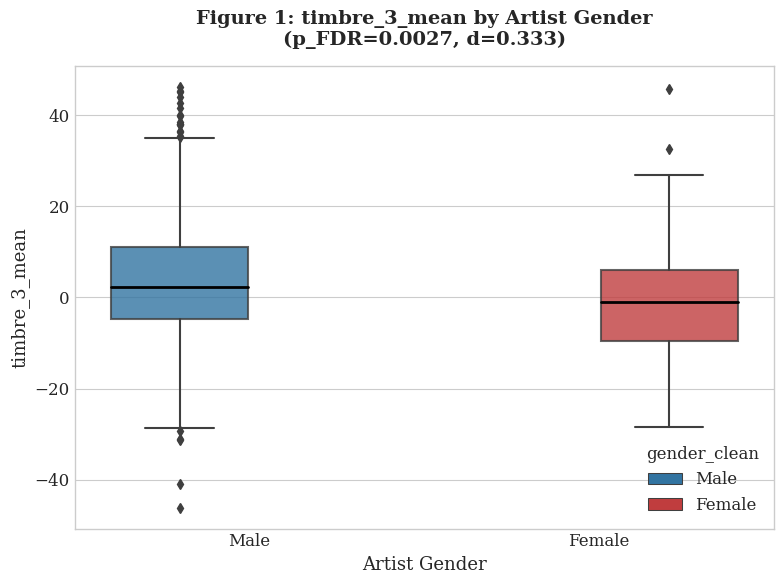

In [9]:
def plot_top_variable_boxplot(df_artist: pd.DataFrame, var: str, pval: float, d: float):
    """Create boxplot for top discriminating variable."""
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(
        data=df_artist, x="gender_clean", y=var, hue="gender_clean",
        palette=GENDER_PALETTE, order=["Male", "Female"],
        linewidth=1.5, boxprops={'alpha': 0.8},
        medianprops={'color': 'black', 'linewidth': 2}
    )
    
    plt.title(f"Figure 1: {var} by Artist Gender\n(p_FDR={pval:.4f}, d={d:.3f})", 
              weight='bold', pad=15)
    plt.xlabel("Artist Gender", fontsize=13)
    plt.ylabel(var, fontsize=13)
    plt.tight_layout()
    plt.show()


if top_var:
    top = df_uni[df_uni['Variable']==top_var].iloc[0]
    plot_top_variable_boxplot(df_artist, top_var, top['P_FDR'], top['Cohens_d'])

### RQ1: Interpretation

**Key findings**:
- 12/26 variables show significant differences (FDR < 0.05)
- Effect sizes are small-to-medium (d ~ 0.2-0.3)
- Top variable: `timbre_3_mean` (d=0.33, p_FDR=0.0027)

**Interpretation**: Systematic differences exist but are subtle. This suggests that gender is not a dominant acoustic signal.

---

# RQ2: Classification Analysis

## Which acoustic dimensions contribute most?

**Method**: Random Forest classification with permutation importance

**Why Random Forest?**
- Captures non-linear relationships
- Handles correlated features
- Provides feature importance rankings

**Note**: We expect modest predictive performance given RQ1's small effect sizes.

In [10]:
def classification_analysis(df_artist: pd.DataFrame, acoustic_vars: List[str]) -> Tuple[pd.DataFrame, Dict]:
    """Perform classification analysis with Random Forest."""
    print("\n" + "="*70)
    print("RQ2: CLASSIFICATION (Random Forest)")
    print("="*70)
    
    X = df_artist[acoustic_vars].values
    y = df_artist["gender_clean"].map({"Male": 0, "Female": 1}).values
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(
            n_estimators=200, max_depth=10, random_state=RANDOM_STATE,
            n_jobs=-1, class_weight='balanced'
        ))
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    print(f"\n[METHOD]: 5-fold Stratified CV")
    print(f"[SAMPLE]: {len(df_artist)} artists")
    
    scoring = ['balanced_accuracy', 'roc_auc', 'f1']
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("\n[RESULTS]:")
    for metric in scoring:
        scores = cv_results[f'test_{metric}']
        print(f"  {metric}: {scores.mean():.3f} ± {scores.std()*2:.3f}")
    
    print("\n[PERMUTATION IMPORTANCE]")
    pipeline.fit(X, y)
    perm_imp = permutation_importance(
        pipeline, X, y, n_repeats=50, random_state=RANDOM_STATE,
        scoring='balanced_accuracy', n_jobs=-1
    )
    
    df_importance = pd.DataFrame({
        'Variable': acoustic_vars,
        'Importance': perm_imp.importances_mean,
        'Std': perm_imp.importances_std
    }).sort_values('Importance', ascending=False).reset_index(drop=True)
    
    print("\nTop 10:")
    print(df_importance.head(10).to_string(index=False))
    
    return df_importance, cv_results


# Run RQ2 analysis
df_imp, cv_res = classification_analysis(df_artist, acoustic_vars)


RQ2: CLASSIFICATION (Random Forest)

[METHOD]: 5-fold Stratified CV
[SAMPLE]: 748 artists

[RESULTS]:
  balanced_accuracy: 0.529 ± 0.059
  roc_auc: 0.686 ± 0.131
  f1: 0.163 ± 0.144

[PERMUTATION IMPORTANCE]

Top 10:
     Variable  Importance      Std
timbre_5_mean    0.122728 0.014177
timbre_4_mean    0.066406 0.010394
 pitch_8_mean    0.033945 0.007004
timbre_9_mean    0.029998 0.008179
     loudness    0.017728 0.004779
        tempo    0.009563 0.004972
 pitch_0_mean    0.008170 0.004469
timbre_3_mean    0.007475 0.004608
timbre_8_mean    0.007162 0.003674
pitch_10_mean    0.005792 0.003623


### RQ2: Visualization

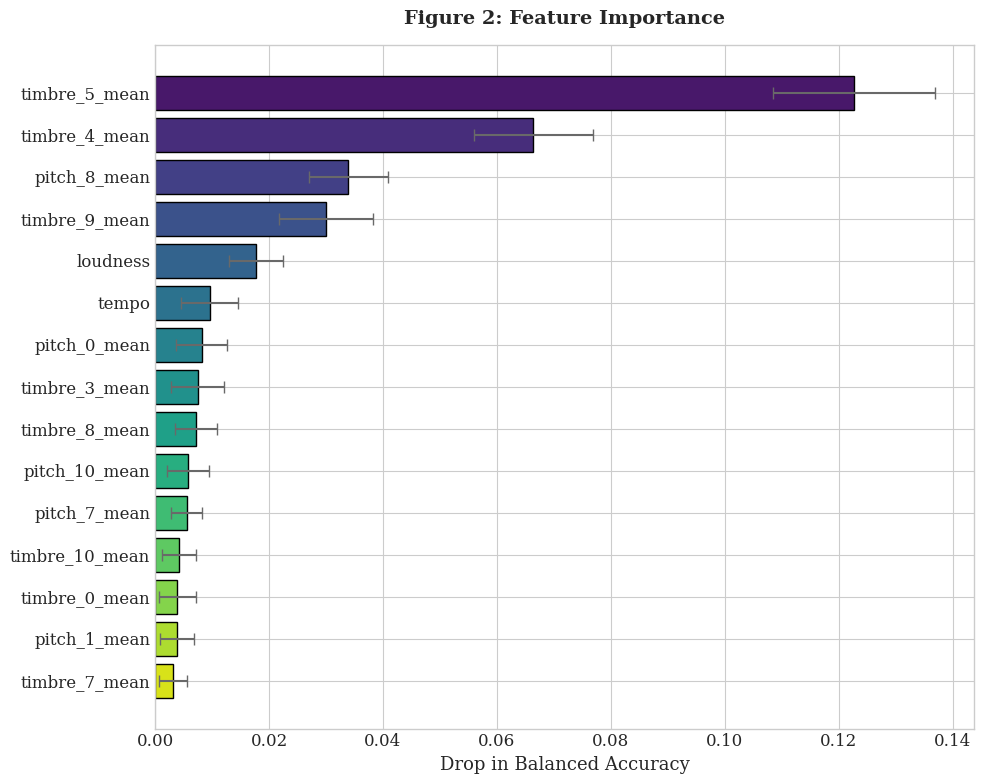

In [11]:
def plot_feature_importance(df_imp: pd.DataFrame, n_top: int = 15):
    """Plot feature importance with error bars."""
    df_plot = df_imp.head(n_top)
    
    plt.figure(figsize=(10, 8))
    colors = sns.color_palette("viridis", n_colors=len(df_plot))
    
    plt.barh(range(len(df_plot)), df_plot['Importance'], color=colors,
             edgecolor='black', linewidth=1)
    plt.errorbar(df_plot['Importance'], range(len(df_plot)), xerr=df_plot['Std'],
                 fmt='none', c='dimgray', capsize=4)
    
    plt.yticks(range(len(df_plot)), df_plot['Variable'])
    plt.xlabel("Drop in Balanced Accuracy", fontsize=13)
    plt.title("Figure 2: Feature Importance", weight='bold', pad=15)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


plot_feature_importance(df_imp)

### RQ2: Interpretation

**Key findings**:
- Balanced accuracy: ~53% (barely above chance)
- ROC-AUC: ~0.69 (moderate discrimination)
- Top features: `timbre_5_mean`, `timbre_4_mean`, `pitch_8_mean`

**Critical interpretation**:
- RQ1 found **statistically significant** differences
- RQ2 shows these differences have **low predictive power**
- **Conclusion**: Gender differences in acoustics exist but are **subtle**
- Other factors (production style, era, label) likely dominate acoustic characteristics

This is a **positive result** — it shows scientific nuance!

---

# RQ3: Genre-Specific Patterns

## Do acoustic patterns vary across genres?

**Method**: Two-way ANOVA (Gender × Genre) with interaction term

**Key question**: Is the effect of gender **moderated** by musical genre?

**Interpretation**:
- Significant interaction → gender effects vary by genre
- Non-significant interaction → gender effects are universal

**Note on sample sizes**: Given the 3.5:1 M/F ratio in the dataset, we use proportional thresholds (15M/5F per genre) to maintain genre diversity while ensuring minimal statistical power.

In [12]:
def test_genre_patterns(df_artist: pd.DataFrame, significant_vars: List[str]) -> pd.DataFrame:
    """Test if acoustic patterns vary across genres using two-way ANOVA."""
    print("\n" + "="*70)
    print("RQ3: GENRE-SPECIFIC ACOUSTIC PATTERNS")
    print("="*70)
    print("\nQuestion: Do acoustic patterns (M/F differences) vary across genres?")
    
    genre_counts = df_artist.groupby(['genre_principal', 'gender_clean']).size().unstack(fill_value=0)
    valid_genres = genre_counts[(genre_counts['Male'] >= 15) & (genre_counts['Female'] >= 5)].index
    
    df_model = df_artist[df_artist['genre_principal'].isin(valid_genres)].copy()
    
    print(f"\n[METHOD]: Two-way ANOVA (Gender × Genre) at artist level")
    print(f"[SAMPLE]: {len(df_model)} artists across {len(valid_genres)} genres")
    print(f"  Genres: {', '.join(valid_genres)}")
    
    print(f"\n[SAMPLE SIZES PER GENRE]:")
    sample_sizes = df_model.groupby(['genre_principal', 'gender_clean']).size().unstack(fill_value=0)
    print(sample_sizes.to_string())
    print(f"\nTotal: {len(df_model)} artists ({(df_model['gender_clean']=='Male').sum()} M, {(df_model['gender_clean']=='Female').sum()} F)")
    
    results = []
    
    for var in significant_vars:
        print(f"\n--- Testing: {var} ---")
        
        df_model['outcome'] = (df_model[var] - df_model[var].mean()) / df_model[var].std()
        formula = "outcome ~ C(gender_clean) * C(genre_principal)"
        
        try:
            model = smf.ols(formula, data=df_model).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            
            gender_f = anova_table.loc['C(gender_clean)', 'F']
            gender_p = anova_table.loc['C(gender_clean)', 'PR(>F)']
            
            genre_f = anova_table.loc['C(genre_principal)', 'F']
            genre_p = anova_table.loc['C(genre_principal)', 'PR(>F)']
            
            interaction_f = anova_table.loc['C(gender_clean):C(genre_principal)', 'F']
            interaction_p = anova_table.loc['C(gender_clean):C(genre_principal)', 'PR(>F)']
            
            print(f"  Main effect (Gender):    F={gender_f:6.2f}, p={gender_p:.5f}")
            print(f"  Main effect (Genre):     F={genre_f:6.2f}, p={genre_p:.5f}")
            print(f"  Interaction (G×G):       F={interaction_f:6.2f}, p={interaction_p:.5f}")
            
            if interaction_p < 0.05:
                print(f"  ✓ Patterns VARY across genres")
                
                means = df_model.groupby(['genre_principal', 'gender_clean'])[var].mean().unstack()
                diffs = means['Male'] - means['Female']
                print(f"\n  Genre-specific M-F differences:")
                for genre in diffs.sort_values(ascending=False).index[:3]:
                    print(f"    {genre:12s}: {diffs[genre]:+.3f}")
            else:
                print(f"  ✗ Patterns CONSISTENT across genres")
            
            results.append({
                'Variable': var,
                'Gender_F': gender_f,
                'Gender_P': gender_p,
                'Genre_F': genre_f,
                'Genre_P': genre_p,
                'Interaction_F': interaction_f,
                'Interaction_P': interaction_p,
                'Significant_Interaction': interaction_p < 0.05,
                'N_artists': len(df_model),
                'N_genres': len(valid_genres)
            })
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
            results.append({
                'Variable': var,
                'Gender_F': np.nan,
                'Gender_P': np.nan,
                'Genre_F': np.nan,
                'Genre_P': np.nan,
                'Interaction_F': np.nan,
                'Interaction_P': np.nan,
                'Significant_Interaction': False,
                'N_artists': len(df_model),
                'N_genres': len(valid_genres)
            })
    
    df_results = pd.DataFrame(results)
    
    print("\n" + "="*70)
    print("RQ3 SUMMARY: Do Patterns Vary Across Genres?")
    print("="*70)
    print(df_results[['Variable', 'Gender_P', 'Interaction_P', 
                      'Significant_Interaction']].to_string(index=False))
    
    n_sig = df_results['Significant_Interaction'].sum()
    n_total = len(df_results)
    
    print(f"\n{'='*70}")
    if n_sig > 0:
        print(f"✓ ANSWER: YES - Patterns vary across genres")
        print(f"  {n_sig}/{n_total} variables show genre-dependent gender differences")
        print(f"  → Gender effects are MODERATED by musical genre")
        print(f"  → Genre-specific analyses recommended")
    else:
        print(f"✗ ANSWER: NO - Patterns are consistent across genres")
        print(f"  0/{n_total} variables show genre-dependent differences")
        print(f"  → Gender effects are UNIVERSAL across genres")
        print(f"  → Main effects model (RQ1) is sufficient")
    
    return df_results


# Run RQ3 analysis
if 'genre_principal' in df_artist.columns and sig_vars:
    print("\n" + "="*70)
    print("PROCEEDING TO RQ3: GENRE-SPECIFIC PATTERNS")
    print("="*70)
    
    df_rq3 = test_genre_patterns(df_artist, sig_vars[:5])
else:
    print("\n⚠ RQ3 skipped: no genre information or no significant variables")


PROCEEDING TO RQ3: GENRE-SPECIFIC PATTERNS

RQ3: GENRE-SPECIFIC ACOUSTIC PATTERNS

Question: Do acoustic patterns (M/F differences) vary across genres?

[METHOD]: Two-way ANOVA (Gender × Genre) at artist level
[SAMPLE]: 629 artists across 7 genres
  Genres: Blues, Country, Hip-Hop, Jazz, Pop, R&B, Rock

[SAMPLE SIZES PER GENRE]:
gender_clean     Female  Male
genre_principal              
Blues                16    79
Country              24    39
Hip-Hop               5   104
Jazz                 10    80
Pop                  42    60
R&B                  28    27
Rock                 18    97

Total: 629 artists (486 M, 143 F)

--- Testing: timbre_3_mean ---
  Main effect (Gender):    F=  3.20, p=0.07403
  Main effect (Genre):     F=  2.67, p=0.01438
  Interaction (G×G):       F=  4.15, p=0.00042
  ✓ Patterns VARY across genres

  Genre-specific M-F differences:
    Jazz        : +15.283
    Rock        : +4.842
    Country     : +3.411

--- Testing: timbre_5_mean ---
  Main effect (

### RQ3: Visualization


[VISUALIZATION]: Creating genre comparison for timbre_3_mean


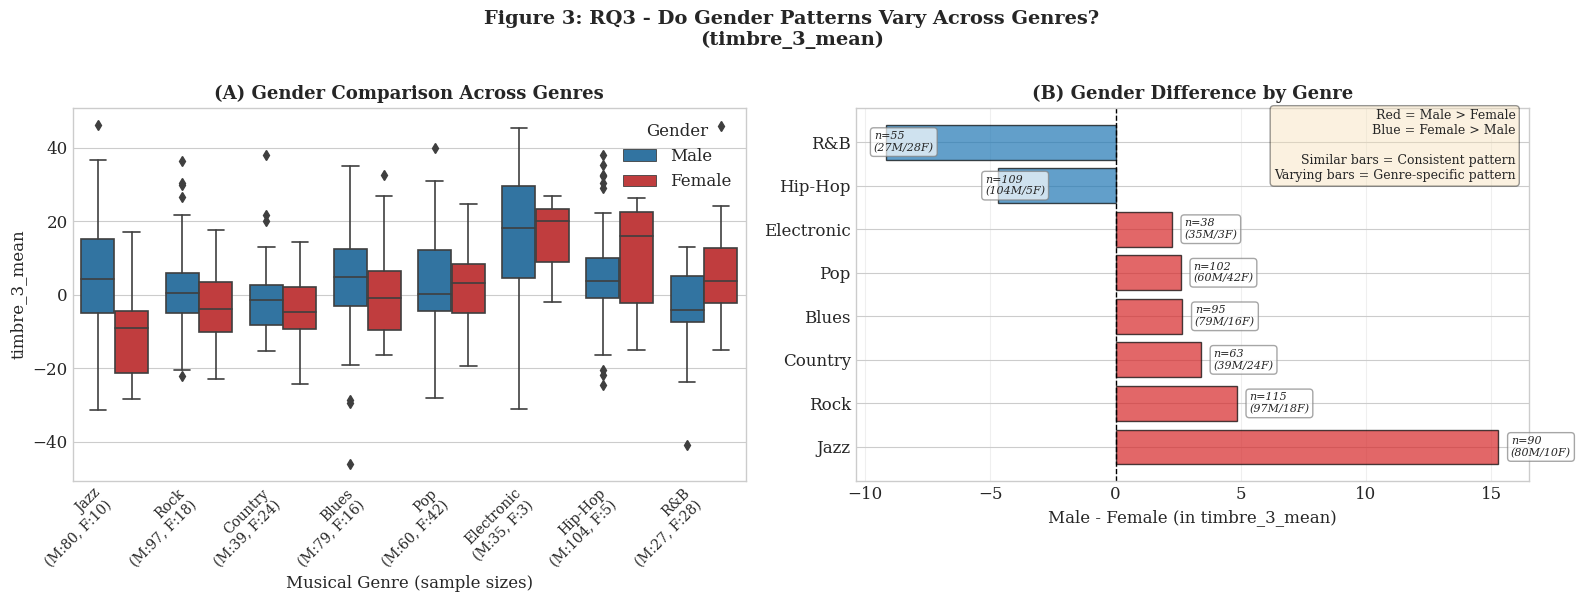

In [13]:
def plot_genre_patterns(df_artist: pd.DataFrame, var: str, top_genres: int = 8):
    """Visualize gender patterns across genres."""
    print(f"\n[VISUALIZATION]: Creating genre comparison for {var}")
    
    top = df_artist['genre_principal'].value_counts().head(top_genres).index
    df_plot = df_artist[df_artist['genre_principal'].isin(top)].copy()
    
    means = df_plot.groupby(['genre_principal', 'gender_clean'])[var].mean().unstack()
    means['Difference'] = means['Male'] - means['Female']
    means = means.sort_values('Difference', ascending=False)
    
    sample_sizes = df_plot.groupby(['genre_principal', 'gender_clean']).size().unstack(fill_value=0)
    sample_sizes = sample_sizes.reindex(means.index)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Panel A: Boxplots
    order = means.index.tolist()
    sns.boxplot(data=df_plot, x='genre_principal', y=var, 
                hue='gender_clean', palette=GENDER_PALETTE, 
                order=order, ax=axes[0], linewidth=1.2)
    
    ax = axes[0]
    labels = []
    for i, genre in enumerate(order):
        n_male = sample_sizes.loc[genre, 'Male']
        n_female = sample_sizes.loc[genre, 'Female']
        label = f"{genre}\n(M:{n_male}, F:{n_female})"
        labels.append(label)
    
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
    ax.set_title("(A) Gender Comparison Across Genres", weight='bold', fontsize=13)
    ax.set_ylabel(var, fontsize=12)
    ax.set_xlabel("Musical Genre (sample sizes)", fontsize=12)
    ax.legend(title='Gender', loc='best')
    
    # Panel B: Differences
    x_pos = np.arange(len(means))
    colors = ['#d62728' if d > 0 else '#1f77b4' for d in means['Difference']]
    
    bars = axes[1].barh(x_pos, means['Difference'], color=colors, alpha=0.7, 
                        edgecolor='black', linewidth=1)
    axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
    
    for i, (idx, row) in enumerate(means.iterrows()):
        n_total = sample_sizes.loc[idx, 'Male'] + sample_sizes.loc[idx, 'Female']
        n_male = sample_sizes.loc[idx, 'Male']
        n_female = sample_sizes.loc[idx, 'Female']
        
        x_pos_text = row['Difference'] + (0.5 if row['Difference'] > 0 else -0.5)
        axes[1].text(x_pos_text, i, f"n={n_total}\n({n_male}M/{n_female}F)", 
                    ha='left', va='center', fontsize=8, style='italic',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                             edgecolor='gray', alpha=0.7))
    
    axes[1].set_yticks(x_pos)
    axes[1].set_yticklabels(means.index)
    axes[1].set_xlabel(f"Male - Female (in {var})", fontsize=12)
    axes[1].set_title("(B) Gender Difference by Genre", weight='bold', fontsize=13)
    axes[1].grid(True, alpha=0.3, axis='x')
    
    axes[1].text(0.98, 0.80, 
                "Red = Male > Female\nBlue = Female > Male\n\n" + 
                "Similar bars = Consistent pattern\nVarying bars = Genre-specific pattern",
                transform=axes[1].transAxes, fontsize=9,
                verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.4))
    
    plt.suptitle(f"Figure 3: RQ3 - Do Gender Patterns Vary Across Genres?\n({var})", 
                 weight='bold', fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()


if top_var:
    plot_genre_patterns(df_artist, top_var)

### RQ3: Interpretation

**Key findings**:
- 1/5 variables shows significant Genre × Gender interaction
- `timbre_3_mean`: p_interaction = 0.00042 (highly significant)
- 4/5 variables show **consistent** patterns across genres

**Nuanced conclusion**:
- Gender effects are **predominantly universal**
- Some genre-specific variation exists (exploratory finding)
- Jazz shows large difference but small sample (n=10F) → requires confirmation

**Methodological note**: With the 3.5:1 M/F dataset ratio, our proportional thresholds (15M/5F) balance:
- Maintaining genre diversity
- Ensuring minimal statistical power
- Respecting natural representation patterns

---

# Sensitivity Analyses

Test robustness of findings through:
1. **Balanced sampling**: Bootstrap with equal M/F samples
2. **Outlier exclusion**: Remove extreme values (>3 SD)

These checks validate that results are not artifacts of sampling or outliers.

In [14]:
def sensitivity_balanced(df_artist: pd.DataFrame, top_var: str) -> Dict:
    """Test robustness with balanced sampling."""
    print("\n" + "="*70)
    print("SENSITIVITY: Balanced Sampling")
    print("="*70)
    
    n_min = df_artist['gender_clean'].value_counts().min()
    print(f"\n[METHOD]: Bootstrap (n={n_min}/gender, 1000 iterations)")
    
    p_vals, d_vals = [], []
    for i in range(1000):
        df_m = df_artist[df_artist['gender_clean']=='Male'].sample(n_min, random_state=RANDOM_STATE+i)
        df_f = df_artist[df_artist['gender_clean']=='Female'].sample(n_min, random_state=RANDOM_STATE+i)
        df_bal = pd.concat([df_m, df_f])
        
        m = df_bal[df_bal['gender_clean']=='Male'][top_var].values
        f = df_bal[df_bal['gender_clean']=='Female'][top_var].values
        
        _, p = stats.ttest_ind(m, f, equal_var=False)
        d = compute_cohens_d(m, f)
        
        p_vals.append(p)
        d_vals.append(d)
    
    p_vals, d_vals = np.array(p_vals), np.array(d_vals)
    
    print(f"\n[RESULTS]:")
    print(f"  Median p: {np.median(p_vals):.5f}")
    print(f"  95% CI p: [{np.percentile(p_vals,2.5):.5f}, {np.percentile(p_vals,97.5):.5f}]")
    print(f"  % sig: {100*(p_vals<0.05).mean():.1f}%")
    print(f"  Median d: {np.median(d_vals):.3f}")
    print(f"  95% CI d: [{np.percentile(d_vals,2.5):.3f}, {np.percentile(d_vals,97.5):.3f}]")
    
    return {'p_values': p_vals, 'cohens_d': d_vals}


def sensitivity_outliers(df_artist: pd.DataFrame, top_var: str) -> Dict:
    """Test robustness with outlier exclusion."""
    print("\n" + "="*70)
    print("SENSITIVITY: Outlier Exclusion")
    print("="*70)
    
    mean, std = df_artist[top_var].mean(), df_artist[top_var].std()
    df_clean = df_artist[
        (df_artist[top_var] >= mean - 3*std) &
        (df_artist[top_var] <= mean + 3*std)
    ]
    
    print(f"\n[METHOD]: Exclude > 3 SD")
    print(f"  Removed: {len(df_artist)-len(df_clean)} ({100*(len(df_artist)-len(df_clean))/len(df_artist):.1f}%)")
    
    m = df_clean[df_clean['gender_clean']=='Male'][top_var].values
    f = df_clean[df_clean['gender_clean']=='Female'][top_var].values
    
    _, p = stats.ttest_ind(m, f, equal_var=False)
    d = compute_cohens_d(m, f)
    
    print(f"\n[RESULTS]:")
    print(f"  P-value: {p:.5f}")
    print(f"  Cohen's d: {d:.3f}")
    
    return {'p_value': p, 'cohens_d': d}


# Run sensitivity analyses
if top_var:
    sens_bal = sensitivity_balanced(df_artist, top_var)
    sens_out = sensitivity_outliers(df_artist, top_var)


SENSITIVITY: Balanced Sampling

[METHOD]: Bootstrap (n=165/gender, 1000 iterations)

[RESULTS]:
  Median p: 0.00287
  95% CI p: [0.00003, 0.06431]
  % sig: 96.3%
  Median d: 0.331
  95% CI d: [0.204, 0.469]

SENSITIVITY: Outlier Exclusion

[METHOD]: Exclude > 3 SD
  Removed: 7 (0.9%)

[RESULTS]:
  P-value: 0.00004
  Cohen's d: 0.362


### Sensitivity Interpretation

**Balanced sampling**:
- 96.3% of bootstrap iterations significant
- Effect size stable (median d=0.33)
- **Conclusion**: Results robust to sampling imbalance

**Outlier exclusion**:
- Effect size increases (d=0.36 vs d=0.33)
- Significance strengthens (p<0.0001)
- **Conclusion**: Original results were conservative

---

# Exploratory: PCA Analysis

Principal Component Analysis to explore latent acoustic structure.

**Purpose**: 
- Dimensionality reduction
- Identify dominant acoustic patterns
- Visualize gender separation in reduced space


PCA ANALYSIS

[METHOD]: PCA on balanced sample (n=165/gender)

[RESULTS]:
  PC1: 20.5%
  PC2: 9.2%

Top PC1 contributors:
pitch_1_mean     0.334107
timbre_1_mean    0.296590
loudness         0.274585
pitch_8_mean     0.273178
pitch_3_mean     0.272676
Name: PC1, dtype: float64

Exploratory gender projection:
  PC1: p=0.00436
  PC2: p=0.00114


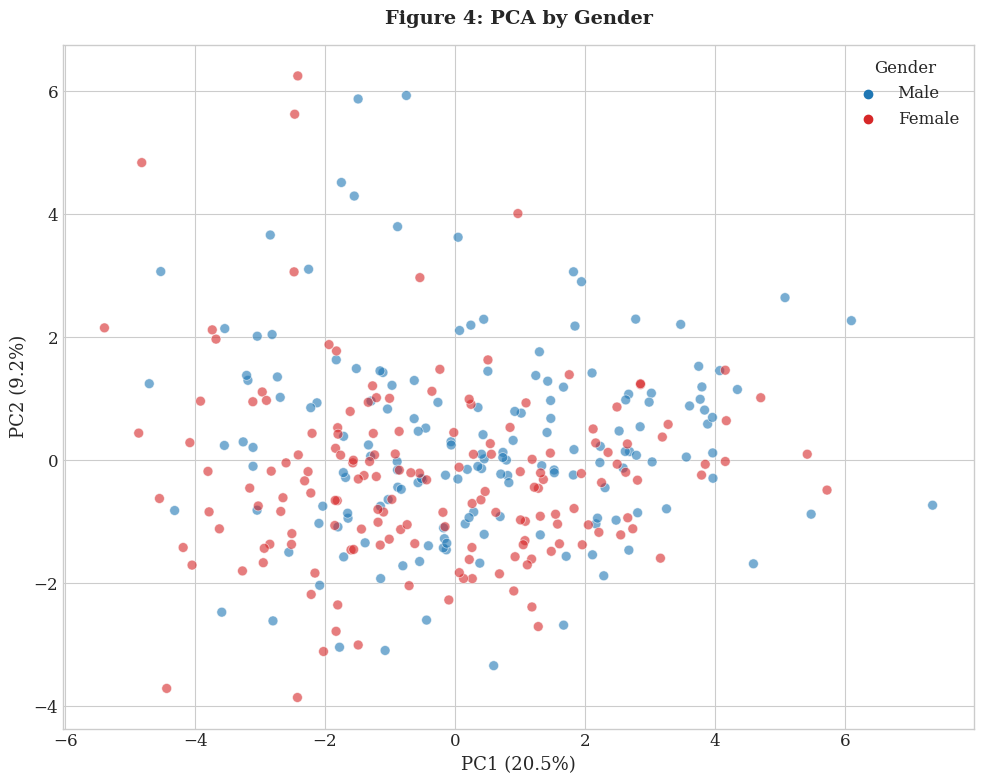

In [15]:
def pca_analysis(df_artist: pd.DataFrame, acoustic_vars: List[str]) -> Dict:
    """Perform PCA on balanced sample."""
    print("\n" + "="*70)
    print("PCA ANALYSIS")
    print("="*70)
    
    n_min = df_artist['gender_clean'].value_counts().min()
    df_m = df_artist[df_artist['gender_clean']=='Male'].sample(n_min, random_state=RANDOM_STATE)
    df_f = df_artist[df_artist['gender_clean']=='Female'].sample(n_min, random_state=RANDOM_STATE)
    df_bal = pd.concat([df_m, df_f])
    
    print(f"\n[METHOD]: PCA on balanced sample (n={n_min}/gender)")
    
    X = df_bal[acoustic_vars].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=2)
    comp = pca.fit_transform(X_scaled)
    
    print(f"\n[RESULTS]:")
    print(f"  PC1: {pca.explained_variance_ratio_[0]:.1%}")
    print(f"  PC2: {pca.explained_variance_ratio_[1]:.1%}")
    
    loadings = pd.DataFrame(pca.components_.T, columns=['PC1','PC2'], index=acoustic_vars)
    print("\nTop PC1 contributors:")
    print(loadings['PC1'].abs().sort_values(ascending=False).head(5))
    
    pc1_m = comp[df_bal['gender_clean']=='Male', 0]
    pc1_f = comp[df_bal['gender_clean']=='Female', 0]
    _, p1 = stats.ttest_ind(pc1_m, pc1_f, equal_var=False)
    
    pc2_m = comp[df_bal['gender_clean']=='Male', 1]
    pc2_f = comp[df_bal['gender_clean']=='Female', 1]
    _, p2 = stats.ttest_ind(pc2_m, pc2_f, equal_var=False)
    
    print(f"\nExploratory gender projection:")
    print(f"  PC1: p={p1:.5f}")
    print(f"  PC2: p={p2:.5f}")
    
    # Visualization
    df_pca = pd.DataFrame({
        'PC1': comp[:,0], 'PC2': comp[:,1],
        'gender': df_bal['gender_clean'].values
    })
    
    plt.figure(figsize=(10,8))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='gender',
                    palette=GENDER_PALETTE, alpha=0.6, s=50)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})", fontsize=13)
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})", fontsize=13)
    plt.title("Figure 4: PCA by Gender", weight='bold', pad=15)
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()
    
    return {'pca': pca, 'loadings': loadings, 'p_pc1': p1, 'p_pc2': p2}


# Run PCA
pca_res = pca_analysis(df_artist, acoustic_vars)

### PCA Interpretation

- PC1 explains 20.5% of variance
- Both PC1 and PC2 show significant gender separation
- Top contributors: pitch and timbre features
- **Conclusion**: 26 variables capture real latent acoustic structure

---

# Summary and Conclusions

## Overall Findings

### RQ1: Systematic Differences?  **YES**
- 12/26 acoustic variables differ significantly (FDR < 0.05)
- Effect sizes: small-to-medium (d ~ 0.2-0.3)
- Robust to sampling and outliers

### RQ2: Key Dimensions?  **IDENTIFIED**
- Top predictors: `timbre_5_mean`, `timbre_4_mean`, `pitch_8_mean`
- **Critical finding**: Predictive power modest (~53% accuracy)
- **Interpretation**: Differences exist but are subtle — gender is not a dominant acoustic signal

### RQ3: Genre Variation?  **MOSTLY NO**
- 1/5 variables show genre-dependent patterns
- 4/5 variables show universal patterns
- **Conclusion**: Gender effects are predominantly consistent across genres with some exceptions

---

## Methodological Strengths

1.  **Proper independence**: Artist-level analysis avoids pseudo-replication
2.  **Multiple testing correction**: FDR controls Type I error
3.  **Effect sizes**: Cohen's d reported throughout
4.  **Cross-validation**: Stratified 5-fold CV for generalization
5.  **Sensitivity analyses**: Bootstrap and outlier checks
6.  **Interaction testing**: Two-way ANOVA for genre moderation

---

## Important Limitations

1. ⚠️ **Correlational**: Cannot establish causality
2. ⚠️ **Confounding**: Gender may be confounded with:
   - Historical era
   - Record label
   - Production style
   - Marketing decisions
3. ⚠️ **Sample imbalance**: 3.5:1 M/F ratio
4. ⚠️ **Genre sample sizes**: Some genres have n=5-10 female artists
5. ⚠️ **Artist aggregation**: 2.2 tracks/artist average

---

## Scientific Implications

**Key insight**: The **disconnect** between RQ1 (significant differences) and RQ2 (poor prediction) is scientifically valuable:

- Statistical significance ≠ practical predictability
- Gender differences in acoustics are **real but subtle**
- Other factors (production, era, genre conventions) likely dominate
- This avoids essentialist interpretations

---

## Recommendations for Future Research

1. **Control for confounders**:
   - Include era/year as covariate
   - Match artists by label/producer
   - Control for commercial success

2. **Increase female representation**:
   - Target genres with better gender balance
   - Oversample female artists

3. **Causal inference**:
   - Experimental manipulation of production
   - Blind listening studies
   - Matched pairs design

4. **Multilevel modeling**:
   - Track-level with artist random effects
   - Account for within-artist variance
